<a href="https://colab.research.google.com/github/royseto/langgraph-tutorials-royseto/blob/main/LangGraph_Quickstart_part_1_openai_royseto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This colab notebook has Roy's work with the LangGraph Quickstart at https://langchain-ai.github.io/langgraph/tutorials/introduction/

# Setup

In [5]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_openai

In [6]:
"""
The LangGraph Quickstart gets API keys interactively using `getpass`.
On colab, get them from colab secrets instead. Commenting this out.

import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")
"""

'\nThe LangGraph Quickstart gets API keys interactively using `getpass`.\nOn colab, get them from colab secrets instead. Commenting this out.\n\nimport getpass\nimport os\n\n\ndef _set_env(var: str):\n    if not os.environ.get(var):\n        os.environ[var] = getpass.getpass(f"{var}: ")\n\n\n_set_env("ANTHROPIC_API_KEY")\n'

In [7]:
import os
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["LANGSMITH_API_KEY"] = userdata.get('LANGSMITH_API_KEY')

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langgraph-quickstart"

# Part 1: Build a Basic Chatbot

In [8]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [9]:
from langchain_openai import ChatOpenAI

#llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm = ChatOpenAI(model="gpt-4o")

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [10]:
graph_builder.add_edge(START, "chatbot")

In [11]:
graph_builder.add_edge("chatbot", END)

In [12]:
graph = graph_builder.compile()

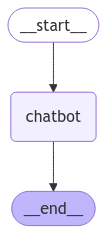

In [13]:
graph

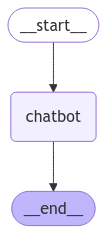

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [15]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: tell me about chunky monkey ice cream
Assistant: Chunky Monkey is a popular ice cream flavor produced by Ben & Jerry's, known for its distinctive combination of flavors and textures. This ice cream features a rich banana base, which is complemented by fudge chunks and walnuts. The blend of banana, chocolate, and nuts creates a unique and indulgent treat that has been well-received by fans of Ben & Jerry's. Like many of their creations, Chunky Monkey is known for its playful name and quirky, fun approach to flavors, aligning with Ben & Jerry's reputation for creative and socially conscious products.
User: What do you know about orangutans?
Assistant: Orangutans are large primates and one of the great apes, which also include gorillas, chimpanzees, and bonobos. They are primarily known for their distinct reddish-brown hair and highly intelligent behavior. Here are some key points about orangutans:

1. **Species and Habitat**: There are three species of orangutans: the Bornean orang

# Part 2: 🛠️ Enhancing the Chatbot with Tools

For Tavily hello world notebook, see https://colab.research.google.com/drive/1P16Y23P-1uSGLkQI50y0IUc3FdYgBGTW

"Tavily Search API is a search engine optimized for LLMs, aimed at efficient, quick and persistent search results." - https://docs.tavily.com/docs/welcome

In [ ]:
%%capture --no-stderr
%pip install -U tavily-python langchain_community

In [ ]:
import os
from google.colab import userdata
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': 'Nodes¶ In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id). Similar to NetworkX, you add these nodes to a graph using the add_node method:'},
 {'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making'}]

In [ ]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


#llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm = ChatAnthropic(model="claude-3-5-sonnet-20241022")
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [ ]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [ ]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

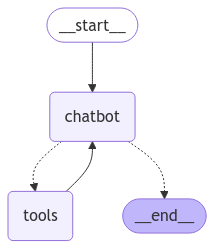

In [ ]:
graph

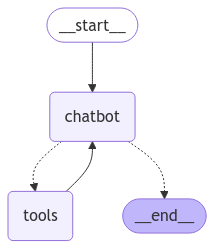

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: Who are the investors in stargate
Assistant: [{'text': "Let me search for information about Stargate's investors.", 'type': 'text'}, {'id': 'toolu_01WJ7GGw8kdsro3WJ8MWbnPQ', 'input': {'query': 'Stargate Protocol investors funding rounds'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Assistant: [{"url": "https://messari.io/project/stargate-finance/fundraising", "content": "Funding Rounds Investors M&A Funds. Watchlists. Screener. Assets M&A Funds Funding Rounds Investors Explore ... Finance is a cross-chain bridge solution built on LayerZero.The STG token is used to reward liquidity providers for funding Stargate Protocol operations, and to lock and receive the Stargate Protocol governance token (veSTG). Totals"}, {"url": "https://tracxn.com/d/companies/stargate/__GPlam86tqPbRYnNxUmkYuvkNy4WkpBeJSFpocPX0ka4", "content": "Stargate - Company Profile - Tracxn Stargate Stargate company profile Stargate - About the company What does Stargate do? Stargate's funding and in

Could do later: Replace the builtin functions for our handwritten ones per the [tutorial instructions](https://langchain-ai.github.io/langgraph/tutorials/introduction/) at the end of part 2.